## AI电力能耗预测大赛树模型实现

# 案例背景

案例数据来源于江苏省镇江扬中市的高新区企业，历史近2年的用电量。希望能够根据历史数据，精准预测未来一个月，每天的用电量。这是一个典型的时序数据回归类问题，我们看看如何用数据驱动建模的方法，来完成这个预测。

In [2]:
from sklearn import preprocessing

In [3]:
# help()方法可以获得说明
help(preprocessing.binarize)

Help on function binarize in module sklearn.preprocessing.data:

binarize(X, threshold=0.0, copy=True)
    Boolean thresholding of array-like or scipy.sparse matrix
    
    Read more in the :ref:`User Guide <preprocessing_binarization>`.
    
    Parameters
    ----------
    X : {array-like, sparse matrix}, shape [n_samples, n_features]
        The data to binarize, element by element.
        scipy.sparse matrices should be in CSR or CSC format to avoid an
        un-necessary copy.
    
    threshold : float, optional (0.0 by default)
        Feature values below or equal to this are replaced by 0, above it by 1.
        Threshold may not be less than 0 for operations on sparse matrices.
    
    copy : boolean, optional, default True
        set to False to perform inplace binarization and avoid a copy
        (if the input is already a numpy array or a scipy.sparse CSR / CSC
        matrix and if axis is 1).
    
    See also
    --------
    Binarizer: Performs binarization usin

### 载入数据

In [5]:
import numpy as np
import pandas as pd

In [6]:
data_1 = pd.read_csv('./zhenjiang_power.csv')

In [7]:
data_1.head()

,user_id,record_date,power_consumption
0,1,2015-01-01,1135.0
1,1,2015-01-02,570.0
2,1,2015-01-03,3418.0
3,1,2015-01-04,3968.0
4,1,2015-01-05,3986.0


In [8]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885486 entries, 0 to 885485
Data columns (total 3 columns):
user_id              885486 non-null int64
record_date          885486 non-null object
power_consumption    885486 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.3+ MB


In [9]:
data_1.describe()

,user_id,power_consumption
count,885486.000000,8.854860e+05
mean,727.500000,2.619980e+03
std,419.733783,3.154743e+04
min,1.000000,1.000000e+00
25%,364.000000,4.200000e+01
50%,727.500000,2.610000e+02
75%,1091.000000,8.250000e+02
max,1454.000000,1.310016e+06


In [10]:
data_2 = pd.read_csv('./zhenjiang_power_9.csv')

In [11]:
data_2.head()

,record_date,user_id,power_consumption
0,2016/9/2,20,1
1,2016/9/3,20,1
2,2016/9/4,20,1
3,2016/9/1,49,1
4,2016/9/2,49,1


In [12]:
# 数据拼接，因为字段の数量、名称都相同，所以可以作拼接
train_df = pd.concat([data_1, data_2])

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [13]:
data_1.shape

(885486, 3)

In [14]:
data_2.shape

(43620, 3)

In [15]:
train_df.shape

(929106, 3)

In [16]:
929106 == 43620 + 885486

True

In [17]:
# 训练数据
train_df.head()

,power_consumption,record_date,user_id
0,1135.0,2015-01-01,1
1,570.0,2015-01-02,1
2,3418.0,2015-01-03,1
3,3968.0,2015-01-04,1
4,3986.0,2015-01-05,1


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929106 entries, 0 to 43619
Data columns (total 3 columns):
power_consumption    929106 non-null float64
record_date          929106 non-null object
user_id              929106 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 28.4+ MB


- 把原数据的时间转为datetime格式

In [19]:
train_df.loc[:, 'record_date'] = pd.to_datetime(train_df['record_date'])

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929106 entries, 0 to 43619
Data columns (total 3 columns):
power_consumption    929106 non-null float64
record_date          929106 non-null datetime64[ns]
user_id              929106 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 28.4 MB


In [21]:
# 把user_id去重，再计算长度，代表企业数量
len(train_df['user_id'].unique())

1454

- 目标：预测未来一个月每一天整个高新区的用电量

In [22]:
# 以日期为分组，对每个企业の用电量求和
train_df = train_df[['record_date', 'power_consumption']].groupby('record_date').agg('sum')

In [23]:
train_df.head()

,power_consumption
record_date,
2015-01-01,2900575.0
2015-01-02,3158211.0
2015-01-03,3596487.0
2015-01-04,3939672.0
2015-01-05,4101790.0


In [24]:
# 弄整齐一点
train_df = train_df.reset_index()
train_df.head()

,record_date,power_consumption
0,2015-01-01,2900575.0
1,2015-01-02,3158211.0
2,2015-01-03,3596487.0
3,2015-01-04,3939672.0
4,2015-01-05,4101790.0


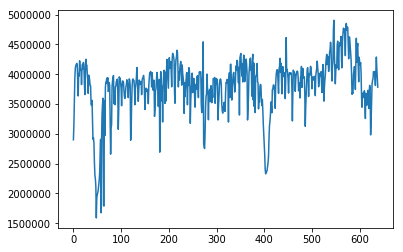

In [25]:
%matplotlib inline
train_df['power_consumption'].plot()

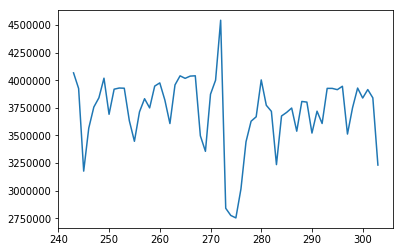

In [26]:
%matplotlib inline
train_df[(train_df['record_date']>='2015-09-01')&(train_df['record_date']<='2015-10-31')]['power_consumption'].plot()

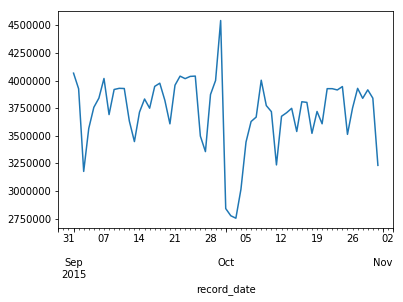

In [27]:
# 把x轴索引转为日期，以便看到引起低谷の原因
%matplotlib inline
tmp_df = train_df[(train_df['record_date']>='2015-09-01')&(train_df['record_date']<='2015-10-31')]
tmp_df = tmp_df.set_index(['record_date'])
tmp_df['power_consumption'].plot()

### 添加测试数据

In [28]:
train_df.tail()

,record_date,power_consumption
634,2016-09-26,4042132.0
635,2016-09-27,4287965.0
636,2016-09-28,4086998.0
637,2016-09-29,3941842.0
638,2016-09-30,3783264.0


In [29]:
test_df = pd.date_range('2016-10-01', periods=31, freq='D')

In [30]:
test_df = pd.DataFrame(test_df)

In [31]:
test_df.head()

,0
0,2016-10-01
1,2016-10-02
2,2016-10-03
3,2016-10-04
4,2016-10-05


In [32]:
# column没名字，起个名吧~
test_df.columns = ['record_date']

In [33]:
# 再新增一列吧，初始化它
test_df.loc[:,'power_consumption'] = 0

In [34]:
test_df.head()

,record_date,power_consumption
0,2016-10-01,0
1,2016-10-02,0
2,2016-10-03,0
3,2016-10-04,0
4,2016-10-05,0


### 拼成一整份数据，做特征工程

In [35]:
total_df = pd.concat([train_df, test_df])

In [36]:
total_df.tail()

,record_date,power_consumption
26,2016-10-27,0.0
27,2016-10-28,0.0
28,2016-10-29,0.0
29,2016-10-30,0.0
30,2016-10-31,0.0


### 构造时间特征

构造一些强时间指代特征：
* 星期几
* 一个月当中的第几天（月初还是月末）
* 一年当中的第几天（季节信息）
* 一年当中的第几个月（季节）、哪一年

In [37]:
tmp = total_df['record_date']

In [38]:
# 星期几
total_df.loc[:,'dow'] = total_df['record_date'].apply(lambda x:x.dayofweek)
# 几号
total_df.loc[:,'dom'] = total_df['record_date'].apply(lambda x:x.day)
# 几月
total_df.loc[:,'month'] = total_df['record_date'].apply(lambda x:x.month)
# 几年
total_df.loc[:,'year'] = total_df['record_date'].apply(lambda x:x.year)

In [39]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year
0,2015-01-01,2900575.0,3,1,1,2015
1,2015-01-02,3158211.0,4,2,1,2015
2,2015-01-03,3596487.0,5,3,1,2015
3,2015-01-04,3939672.0,6,4,1,2015
4,2015-01-05,4101790.0,0,5,1,2015


#### 添加周末特征

In [40]:
total_df.loc[:,'weekend'] = 0
total_df.loc[:,'weekend_sat'] = 0
total_df.loc[:,'weekend_sun'] = 0

In [41]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year,weekend,weekend_sat,weekend_sun
0,2015-01-01,2900575.0,3,1,1,2015,0,0,0
1,2015-01-02,3158211.0,4,2,1,2015,0,0,0
2,2015-01-03,3596487.0,5,3,1,2015,0,0,0
3,2015-01-04,3939672.0,6,4,1,2015,0,0,0
4,2015-01-05,4101790.0,0,5,1,2015,0,0,0


In [42]:
total_df.loc[(total_df['dow']>4), 'weekend'] = 1

In [43]:
total_df.loc[(total_df['dow']==5), 'weekend_sat'] = 1
total_df.loc[(total_df['dow']==6), 'weekend_sun'] = 1

#### 添加一个月4周的信息（第几周）

In [44]:
def week_of_month(day):
    if day in range(1,8):
        return 1
    if day in range(8,15):
        return 2
    if day in range(15,22):
        return 3
    else:
        return 4
total_df.loc[:, 'week_of_month'] = total_df['dom'].apply(lambda x:week_of_month(x))

In [45]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year,weekend,weekend_sat,weekend_sun,week_of_month
0,2015-01-01,2900575.0,3,1,1,2015,0,0,0,1
1,2015-01-02,3158211.0,4,2,1,2015,0,0,0,1
2,2015-01-03,3596487.0,5,3,1,2015,1,1,0,1
3,2015-01-04,3939672.0,6,4,1,2015,1,0,1,1
4,2015-01-05,4101790.0,0,5,1,2015,0,0,0,1


#### 添加上中下旬（第几旬）

In [46]:
def period_of_month(day):
    if day in range(1,11):
        return 1
    if day in range(11,21):
        return 2
    else:
        return 3
total_df.loc[:, 'period_of_month'] = total_df['dom'].apply(lambda x:period_of_month(x))

#### 添加上半月和下半月

In [47]:
def period2_of_month(day):
    if day in range(1,16):
        return 1
    else:
        return 2
total_df.loc[:, 'period2_of_month'] = total_df['dom'].apply(lambda x:period2_of_month(x))

In [48]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year,weekend,weekend_sat,weekend_sun,week_of_month,period_of_month,period2_of_month
0,2015-01-01,2900575.0,3,1,1,2015,0,0,0,1,1,1
1,2015-01-02,3158211.0,4,2,1,2015,0,0,0,1,1,1
2,2015-01-03,3596487.0,5,3,1,2015,1,1,0,1,1,1
3,2015-01-04,3939672.0,6,4,1,2015,1,0,1,1,1,1
4,2015-01-05,4101790.0,0,5,1,2015,0,0,0,1,1,1


#### 填充法定节假日

In [49]:
total_df.loc[:, 'festival'] = 0

In [50]:
total_df.loc[(total_df.month==10)&(total_df.dom<8), 'festival'] = 1

In [51]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year,weekend,weekend_sat,weekend_sun,week_of_month,period_of_month,period2_of_month,festival
0,2015-01-01,2900575.0,3,1,1,2015,0,0,0,1,1,1,0
1,2015-01-02,3158211.0,4,2,1,2015,0,0,0,1,1,1,0
2,2015-01-03,3596487.0,5,3,1,2015,1,1,0,1,1,1,0
3,2015-01-04,3939672.0,6,4,1,2015,1,0,1,1,1,1,0
4,2015-01-05,4101790.0,0,5,1,2015,0,0,0,1,1,1,0


In [52]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670 entries, 0 to 30
Data columns (total 13 columns):
record_date          670 non-null datetime64[ns]
power_consumption    670 non-null float64
dow                  670 non-null int64
dom                  670 non-null int64
month                670 non-null int64
year                 670 non-null int64
weekend              670 non-null int64
weekend_sat          670 non-null int64
weekend_sun          670 non-null int64
week_of_month        670 non-null int64
period_of_month      670 non-null int64
period2_of_month     670 non-null int64
festival             670 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(11)
memory usage: 73.3 KB


线性模型：WX+b，
而星期几是类别型特征，需先进行one-hot encoding

### 分离训练集和测试集

In [53]:
# 训练集，获取2016年10月的都要
train_x = total_df[total_df.record_date<'2016-10-01']
train_y = total_df[total_df.record_date<'2016-10-01']['power_consumption']

test_x = total_df[total_df.record_date>='2016-10-01']

In [54]:
train_x.head()

,record_date,power_consumption,dow,dom,month,year,weekend,weekend_sat,weekend_sun,week_of_month,period_of_month,period2_of_month,festival
0,2015-01-01,2900575.0,3,1,1,2015,0,0,0,1,1,1,0
1,2015-01-02,3158211.0,4,2,1,2015,0,0,0,1,1,1,0
2,2015-01-03,3596487.0,5,3,1,2015,1,1,0,1,1,1,0
3,2015-01-04,3939672.0,6,4,1,2015,1,0,1,1,1,1,0
4,2015-01-05,4101790.0,0,5,1,2015,0,0,0,1,1,1,0


In [55]:
# 去掉'record_date', 'power_consumption'两列
drop_columns = ['record_date', 'power_consumption']
train_x = train_x.drop(drop_columns, axis=1)
test_x = test_x.drop(drop_columns, axis=1)

In [56]:
train_x.columns

Index(['dow', 'dom', 'month', 'year', 'weekend', 'weekend_sat', 'weekend_sun',
       'week_of_month', 'period_of_month', 'period2_of_month', 'festival'],
      dtype='object')

### 树模型建模

In [57]:
import sklearn

In [58]:
from sklearn.ensemble import RandomForestRegressor

In [59]:
# 网格搜索交叉验证
from sklearn.model_selection import GridSearchCV

In [60]:
help(RandomForestRegressor)

Help on class RandomForestRegressor in module sklearn.ensemble.forest:

class RandomForestRegressor(ForestRegressor)
 |  A random forest regressor.
 |  
 |  A random forest is a meta estimator that fits a number of classifying
 |  decision trees on various sub-samples of the dataset and use averaging
 |  to improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="mse")
 |      The function to measure the quality of a split. Supported criteria
 |      are "mse" for the mean squared error, which is equal to variance
 |      reduction as feature selection criterion, and "mae" for the mean
 |      absolute 

In [61]:
# 参数字典
param_grid = {'n_estimators':[5,10,20,50,100,200],#多少棵树
             'max_depth':[3,5,7],#最大树深
             'max_features':[0.6,0.7,0.8]}#最大采样特征比例，

In [62]:
# 初始化
rf = RandomForestRegressor()

In [63]:
# 创建网格搜索交叉验证的对象，GridSearchCV（验证对象，参数字典，3折交叉验证，同时用8个核）
grid = GridSearchCV(rf, param_grid=param_grid, cv=3, n_jobs=8)

In [66]:
grid.fit(train_x, train_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'max_depth': [3, 5, 7], 'n_estimators': [5, 10, 20, 50, 100, 200], 'max_features': [0.6, 0.7, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [67]:
grid.best_params_

{'max_depth': 3, 'max_features': 0.6, 'n_estimators': 10}

In [68]:
rf_reg = grid.best_estimator_

### 特征重要度分析

In [70]:
# 特征重要度
rf_reg.feature_importances_

array([0.11823611, 0.04438879, 0.64068414, 0.11509193, 0.01564044,
       0.        , 0.01333794, 0.01127093, 0.00817801, 0.        ,
       0.03317171])

In [71]:
# 可视化一下，看得更清晰
%matplotlib inline
import matplotlib.pyplot as plt

In [72]:
train_x.columns

Index(['dow', 'dom', 'month', 'year', 'weekend', 'weekend_sat', 'weekend_sun',
       'week_of_month', 'period_of_month', 'period2_of_month', 'festival'],
      dtype='object')

In [75]:
print('特征排序：')
feature_names=['dow', 'dom', 'month', 'year', 'weekend', 'weekend_sat', 'weekend_sun','week_of_month', 'period_of_month', 'period2_of_month', 'festival']
feature_importances = rf_reg.feature_importances_
# 重要度从大到小排列
indices = np.argsort(feature_importances)[::-1]

for feature in indices:
    print('feature %s (%f)' %(feature_names[feature], feature_importances[feature]))

特征排序：
feature month (0.640684)
feature dow (0.118236)
feature year (0.115092)
feature dom (0.044389)
feature festival (0.033172)
feature weekend (0.015640)
feature weekend_sun (0.013338)
feature week_of_month (0.011271)
feature period_of_month (0.008178)
feature period2_of_month (0.000000)
feature weekend_sat (0.000000)


([<matplotlib.axis.XTick at 0x7f4aa136e898>,
 <a list of 11 Text xticklabel objects>)

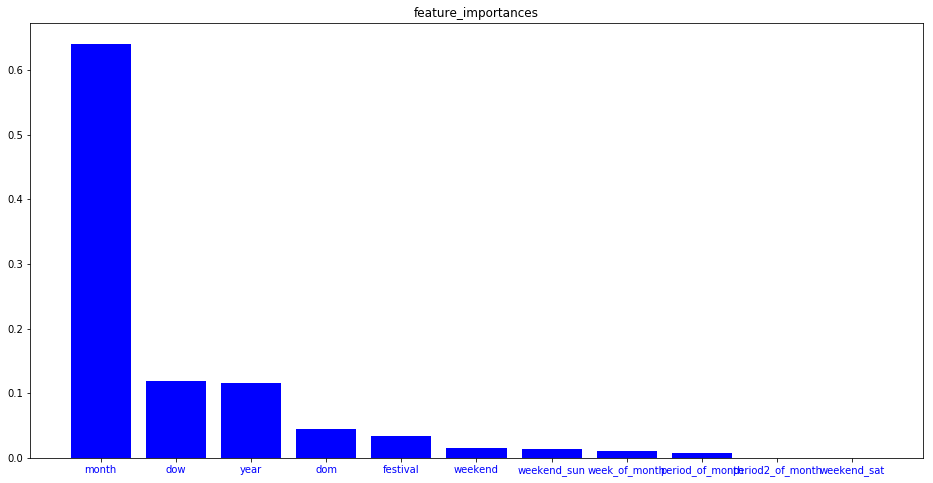

In [78]:
plt.figure(figsize=(16,8))
plt.title("feature_importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], color='b')
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], color='b')

### 进行结果预测

In [79]:
predictions = rf_reg.predict(test_x)

In [80]:
predictions

array([3539113.16128178, 3354011.52669902, 3923375.46593503,
       3923375.46593503, 3856635.86593503, 3776093.95482392,
       3776093.95482392, 3955723.19039124, 3706565.61848584,
       4020526.96193982, 4048815.85625741, 4048815.85625741,
       4048815.85625741, 4048815.85625741, 3955723.19039124,
       3706565.61848584, 4048815.85625741, 4048815.85625741,
       4048815.85625741, 4048815.85625741, 4048815.85625741,
       3955723.19039124, 3706565.61848584, 4048815.85625741,
       4048815.85625741, 4048815.85625741, 4048815.85625741,
       4048815.85625741, 3955723.19039124, 3706565.61848584,
       4048815.85625741])

In [81]:
test_df.head()

,record_date,power_consumption
0,2016-10-01,0
1,2016-10-02,0
2,2016-10-03,0
3,2016-10-04,0
4,2016-10-05,0


In [82]:
test_df.loc[:,'power_consumption'] = predictions

In [83]:
test_df.head()

,record_date,power_consumption
0,2016-10-01,3.539113e+06
1,2016-10-02,3.354012e+06
2,2016-10-03,3.923375e+06
3,2016-10-04,3.923375e+06
4,2016-10-05,3.856636e+06


In [84]:
# 保存预测结果值
test_df.to_csv('tree_model_reg.csv', index=None)